In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [83]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, experimental
from keras.layers.normalization import batch_normalization_v1 import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
def extract_label(yhat):
  index = np.argmax(yhat)
  if index == 0:
    print("The image is from a adenocarcinoma [0]")
  elif index == 1:
    print("The image is from a large cell carcinoma [1]")
  elif index == 2:
    print("The image is from a normal lung [2]")
  else:
    print("The image is from a squamous cell carcinoma [3]")

In [4]:
# Used to avoid OutOfMemory Erros by limiting GPU consumption of memory
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Remove non valid images <h2>

In [6]:
data_dir = r"/content/drive/MyDrive/Colab Notebooks/Adenocarcionoma_detection/data"
valid_exts = ["jpg", "jpeg", "bmp", "png"]

In [7]:
# Making sure is the correct path
data_list = os.listdir(data_dir)
print(data_list)

['test', 'train', 'valid']


In [8]:
os.listdir(os.path.join(data_dir, "train", "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"))[:5]

['000025 (6).png',
 '000016 (9).png',
 '000023 (9).png',
 '000020 (5).png',
 '000014 (7).png']

In [9]:
path = os.path.join(data_dir, "train", "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib", "000005 (9).png")
imag = cv2.imread(path)
tip = imghdr.what(path)
print(f"Img: {imag} ----------> tip: {tip}")

Img: [[[0 0 0]
  [0 0 0]
  [1 1 1]
  ...
  [2 2 2]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [3 3 3]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]] ----------> tip: png


In [10]:
# IMAGES ARE VALID
"""
for image_class in os.listdir(os.path.join(data_dir)):
    for diag_class in os.listdir(os.path.join(data_dir, image_class)):
        for image in os.listdir(os.path.join(data_dir, image_class, diag_class)):
            image_path = os.path.join(data_dir, image_class)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print(f"Image not in ext list {image_path}")
                    os.remove(image_path)
            except Exception as e:
                    print(f"Issue with image {image_path}")
"""

'\nfor image_class in os.listdir(os.path.join(data_dir)):\n    for diag_class in os.listdir(os.path.join(data_dir, image_class)):\n        for image in os.listdir(os.path.join(data_dir, image_class, diag_class)):\n            image_path = os.path.join(data_dir, image_class)\n            try:\n                img = cv2.imread(image_path)\n                tip = imghdr.what(image_path)\n                if tip not in image_exts:\n                    print(f"Image not in ext list {image_path}")\n                    os.remove(image_path)\n            except Exception as e:\n                    print(f"Issue with image {image_path}")\n'

<h2> Loading data <h2>

In [11]:
tf.keras.utils.image_dataset_from_directory??

In [12]:
train = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Adenocarcionoma_detection/data/train",
                                                    image_size=(224,224), batch_size=64) # Training is 70%
test = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Adenocarcionoma_detection/data/test",
                                                   image_size=(224,224), batch_size=64) # Testing is 20%
valid = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Adenocarcionoma_detection/data/valid",
                                                    image_size=(224,224), batch_size=64) # Validation is 10%

Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.


In [13]:
train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
path = os.path.join(data_dir, "train", "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib", "000005 (9).png")
imag = cv2.imread(path)

#Scale data

In [15]:
train = train.map(lambda x,y: (x/255, y))
test = test.map(lambda x,y: (x/255, y))
valid = valid.map(lambda x,y: (x/255, y))

In [ ]:
train.as_numpy_iterator().next()
test.as_numpy_iterator().next()
valid.as_numpy_iterator().next()

In [17]:
print(f"Max: {test.as_numpy_iterator().next()[0].max()}, min: {test.as_numpy_iterator().next()[0].min()}")

Max: 1.0, min: 0.0


# Creating the model

In [35]:
# Initialize the model
model = Sequential()

In [36]:
# We apply VGG16
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [37]:
resize_and_rescale = tf.keras.Sequential([
    experimental.preprocessing.Resizing(224,224),
    experimental.preprocessing.Rescaling(1.0/255)
])

In [38]:
data_augmentation = tf.keras.Sequential([
    experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    experimental.preprocessing.RandomRotation(0.2)
])

In [39]:
# Freezing the layers
for layer in base_model.layers:
  layer.trainable=False
  print(layer)

In [86]:
model = Sequential()
#model.add(resize_and_rescale)
#model.add(data_augmentation)
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(batch_normalization_v1.BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32,activation="relu"))
model.add(batch_normalization_v1.BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4,activation="softmax"))

In [87]:
model.compile("adam", loss=tf.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [88]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 32)                802848    
                                                     

In [89]:
# Training the model
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir="logs")
hist = model.fit(train, epochs=60, validation_data=valid, verbose=1, callbacks=[tensorboard_callbacks])

Epoch 1/60
10/10 [==============================] - 11s 510ms/step - loss: 1.2794 - accuracy: 0.5155 - val_loss: 0.9410 - val_accuracy: 0.6528
Epoch 2/60
10/10 [==============================] - 7s 496ms/step - loss: 0.5899 - accuracy: 0.7961 - val_loss: 0.7358 - val_accuracy: 0.7222
Epoch 3/60
10/10 [==============================] - 7s 489ms/step - loss: 0.4644 - accuracy: 0.8369 - val_loss: 0.6423 - val_accuracy: 0.7500
Epoch 4/60
10/10 [==============================] - 8s 409ms/step - loss: 0.3635 - accuracy: 0.8923 - val_loss: 0.5846 - val_accuracy: 0.7500
Epoch 5/60
10/10 [==============================] - 6s 404ms/step - loss: 0.2857 - accuracy: 0.9217 - val_loss: 0.5274 - val_accuracy: 0.8056
Epoch 6/60
10/10 [==============================] - 8s 476ms/step - loss: 0.2437 - accuracy: 0.9201 - val_loss: 0.4896 - val_accuracy: 0.8611
Epoch 7/60
10/10 [==============================] - 7s 445ms/step - loss: 0.1896 - accuracy: 0.9543 - val_loss: 0.4552 - val_accuracy: 0.8750
Epoch

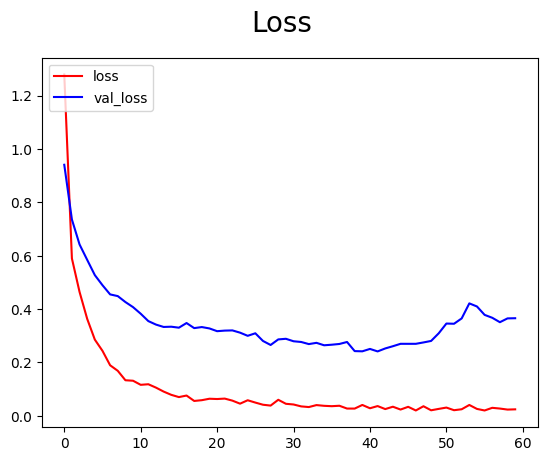

In [90]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="red", label="loss")
plt.plot(hist.history["val_loss"], color="blue", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

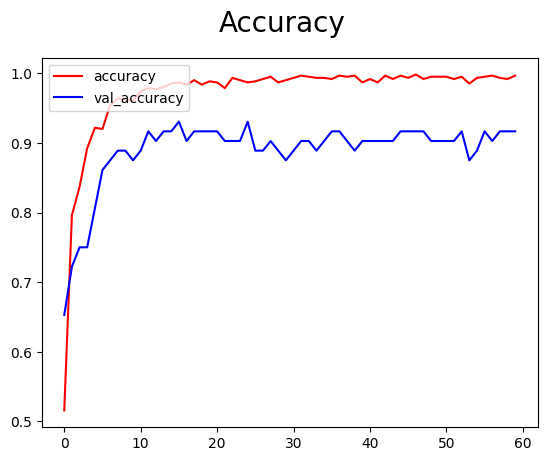

In [91]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="red", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="blue", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

#Evaluate the model

In [92]:
model.evaluate(test, verbose=1)

5/5 [==============================] - 3s 286ms/step - loss: 0.8566 - accuracy: 0.7524


[0.8566253185272217, 0.7523809671401978]

##Manual testing



#[0] is adenocarcinoma
#[1] is large cell carcinoma
#[2] is normal lung
#[3] is squamous cell carcinoma





In [51]:
# The image provided corresponds to the class "adenocarcinoma"

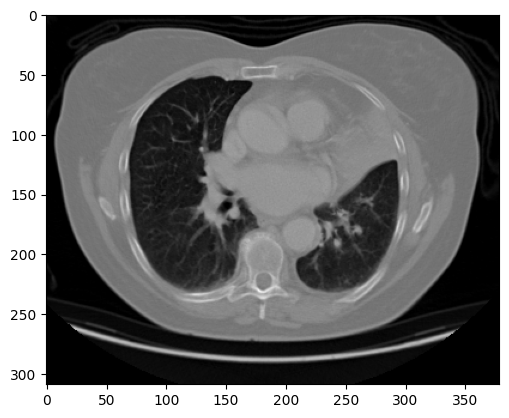

In [74]:
path = os.path.join(data_dir, "test", "adenocarcinoma", "000114 (5).png")
img = cv2.imread(path)
plt.imshow(img)
plt.show()

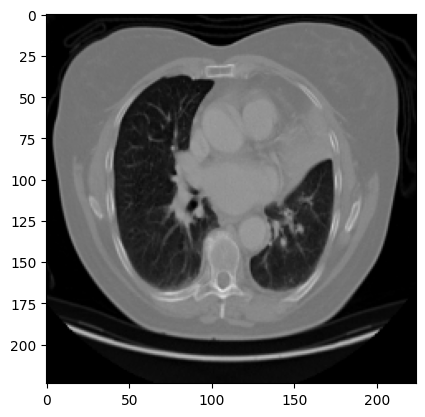

In [75]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [76]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 20ms/step


array([[9.9908841e-01, 2.0063866e-04, 5.3745660e-04, 1.7350072e-04]],
      dtype=float32)

In [77]:
extract_label(yhat)

The image is from a adenocarcinoma [0]


In [69]:
class_names = os.listdir(os.path.join(data_dir, "test"))
class_names

['normal', 'squamous.cell.carcinoma', 'adenocarcinoma', 'large.cell.carcinoma']

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


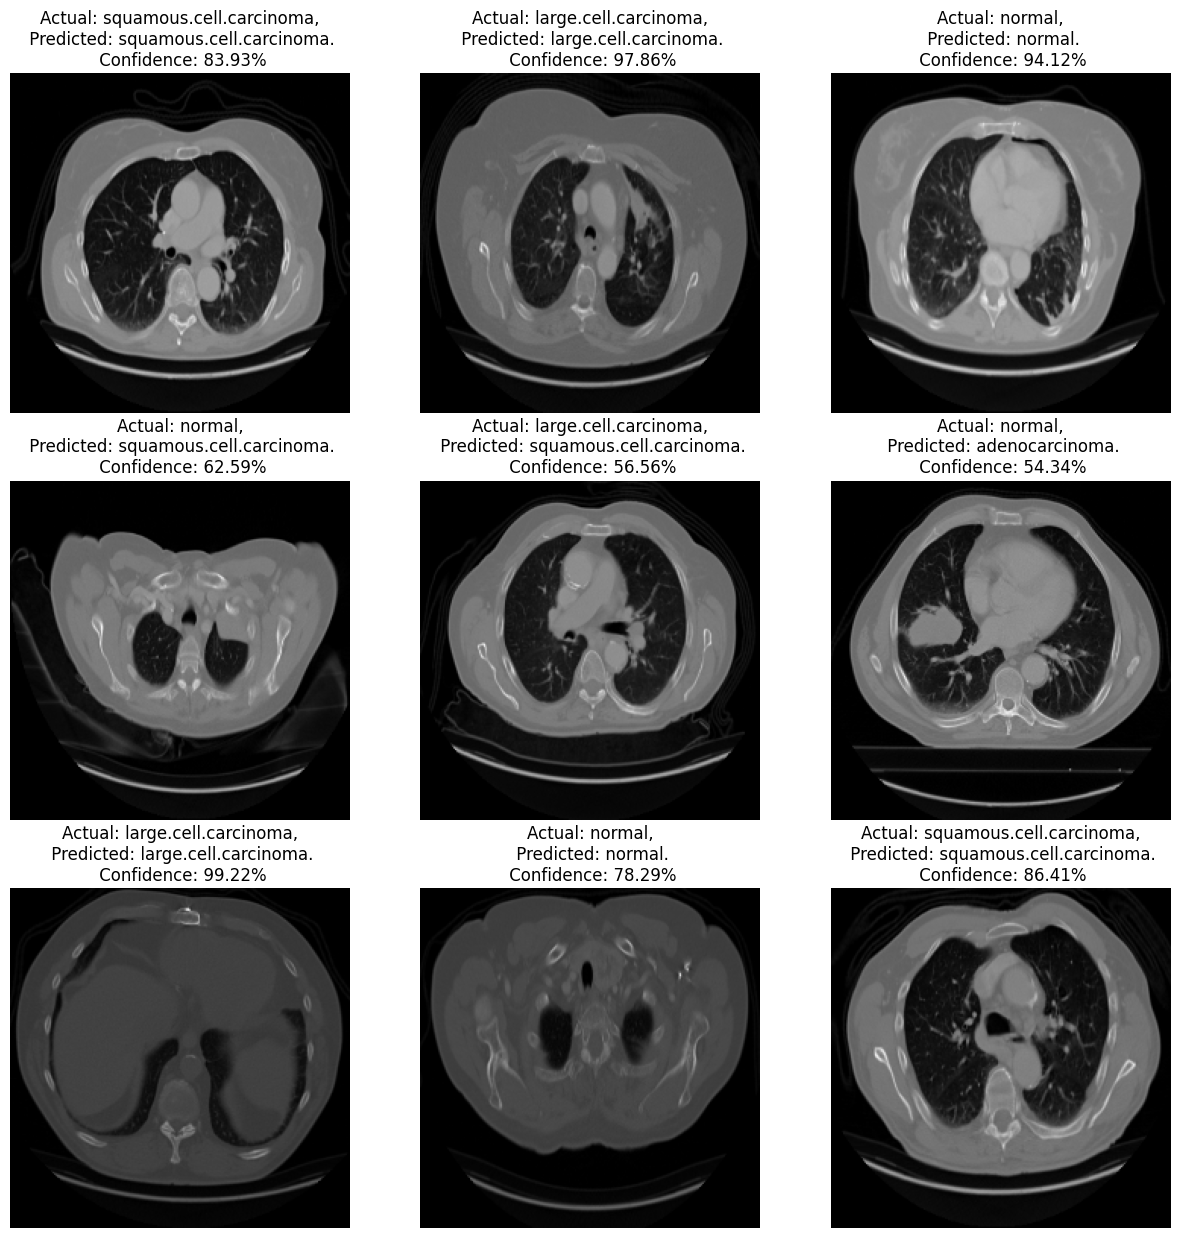

In [79]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

#The image was predicted correctly!

In [81]:
# Saving the model

In [96]:
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/Adenocarcionoma_detection/Models") + [0]])+1
model_version

2

In [93]:
model.save(f"/content/drive/MyDrive/Colab Notebooks/Adenocarcionoma_detection/Models/{model_version}")